In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [ ]:
#load the class labels our YOLO model was trained on
labelsPath = '/content/drive/MyDrive/Detection/data/names/obj.names'
LABELS = open(labelsPath).read().strip().split("\n")

In [ ]:
#load weights and cfg
weightsPath = '/content/drive/MyDrive/Detection/data/weights/' + 'crop_weed_new.weights'
configPath = '/content/drive/MyDrive/Detection/data/cfg/crop_weed.cfg'

In [ ]:
#color selection for drawing bbox
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")

In [ ]:
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [ ]:
#load our input image and grab its spatial dimensions
image = cv2.imread('/content/drive/MyDrive/Detection/data/images/crop_1.jpeg')
(H, W) = image.shape[:2]

In [ ]:
#parameters
confi = 0.5
thresh = 0.3

In [ ]:
net.getLayerNames()

('conv_0',
 'bn_0',
 'leaky_1',
 'conv_1',
 'bn_1',
 'leaky_2',
 'conv_2',
 'bn_2',
 'leaky_3',
 'conv_3',
 'bn_3',
 'leaky_4',
 'shortcut_4',
 'conv_5',
 'bn_5',
 'leaky_6',
 'conv_6',
 'bn_6',
 'leaky_7',
 'conv_7',
 'bn_7',
 'leaky_8',
 'shortcut_8',
 'conv_9',
 'bn_9',
 'leaky_10',
 'conv_10',
 'bn_10',
 'leaky_11',
 'shortcut_11',
 'conv_12',
 'bn_12',
 'leaky_13',
 'conv_13',
 'bn_13',
 'leaky_14',
 'conv_14',
 'bn_14',
 'leaky_15',
 'shortcut_15',
 'conv_16',
 'bn_16',
 'leaky_17',
 'conv_17',
 'bn_17',
 'leaky_18',
 'shortcut_18',
 'conv_19',
 'bn_19',
 'leaky_20',
 'conv_20',
 'bn_20',
 'leaky_21',
 'shortcut_21',
 'conv_22',
 'bn_22',
 'leaky_23',
 'conv_23',
 'bn_23',
 'leaky_24',
 'shortcut_24',
 'conv_25',
 'bn_25',
 'leaky_26',
 'conv_26',
 'bn_26',
 'leaky_27',
 'shortcut_27',
 'conv_28',
 'bn_28',
 'leaky_29',
 'conv_29',
 'bn_29',
 'leaky_30',
 'shortcut_30',
 'conv_31',
 'bn_31',
 'leaky_32',
 'conv_32',
 'bn_32',
 'leaky_33',
 'shortcut_33',
 'conv_34',
 'bn_34',
 'l

In [ ]:
net.getUnconnectedOutLayers()

array([200, 227, 254], dtype=int32)

[INFO] YOLO took 1.061012 seconds


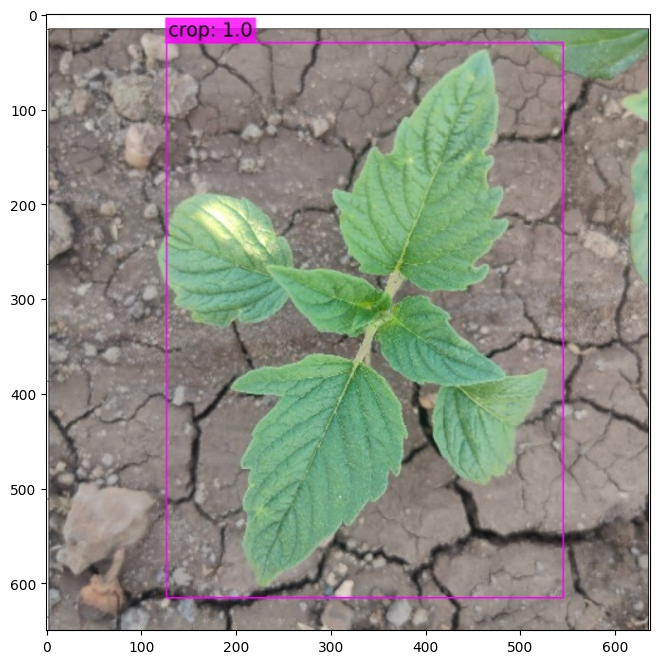

In [ ]:
#determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

#construct a blob from the input image and then perform a forward
#pass of the YOLO object detector, giving us our bounding boxes and
#associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (512, 512),swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()

#show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

#initialize our lists of detected bounding boxes, confidences, and
#class IDs, respectively
boxes = []
confidences = []
classIDs = []

#loop over each of the layer outputs
for output in layerOutputs:
	#loop over each of the detections
	for detection in output:
		#extract the class ID and confidence (i.e., probability) of
		#the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]

		#filter out weak predictions by ensuring the detected
		#probability is greater than the minimum probability
		if confidence > confi:
			#scale the bounding box coordinates back relative to the
			#size of the image, keeping in mind that YOLO actually
			#returns the center (x, y)-coordinates of the bounding
			#box followed by the boxes' width and height
			boxes = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = boxes.astype("int")

			#use the center (x, y)-coordinates to derive the top and
			#and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))

			#update our list of bounding box coordinates, confidences,
			#and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

#apply non-maxima suppression to suppress weak, overlapping bounding
#boxes
#idxs = cv2.dnn.NMSBoxes(boxes, confidences, confi, thresh)

#ensure at least one detection exists
if len(boxes) > 0:
	#loop over the indexes we are keeping
	for i in boxes.flatten():
		#extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])

		#draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)
det = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,8))
plt.imshow(det)